In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import segmentation_models as sm
import tensorflow as tf
import numpy as np
import utils_tf1
from glob import glob
import cv2
import matplotlib.pyplot as plt

Segmentation Models: using `tf.keras` framework.


In [3]:
BACKBONE = 'efficientnetb4'
BATCH_SIZE = 8
CLASSES = ['paddy']
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)
activation = 'sigmoid' if n_classes == 1 else 'softmax'

class Model:
    def __init__(self, img_size=256):
        self.X = tf.placeholder(tf.float32, (None, img_size, img_size, 3))
        X = tf.identity(self.X, name = 'input')
        model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
        self.logits = model(X)
        self.logits = tf.identity(self.logits, name = 'logits')

In [4]:
tf.compat.v1.reset_default_graph()
model = Model()

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [5]:
model.logits

<tf.Tensor 'logits:0' shape=(?, 256, 256, 1) dtype=float32>

In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [7]:
checkpoint_file = 'efficientnetb4-unet-jelapang-padi/model.ckpt-5000'
var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
assignment_map, initialized_variable_names = utils_tf1.get_assignment_map_from_checkpoint(var_list, 
                                                                                          checkpoint_file)


INFO:tensorflow:**** Trainable Variables ****
INFO:tensorflow:  name = stem_conv/kernel:0, shape = (3, 3, 3, 48), *INIT_FROM_CKPT*
INFO:tensorflow:  name = stem_bn/gamma:0, shape = (48,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = stem_bn/beta:0, shape = (48,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = stem_bn/moving_mean:0, shape = (48,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = stem_bn/moving_variance:0, shape = (48,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = block1a_dwconv/depthwise_kernel:0, shape = (3, 3, 48, 1), *INIT_FROM_CKPT*
INFO:tensorflow:  name = block1a_bn/gamma:0, shape = (48,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = block1a_bn/beta:0, shape = (48,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = block1a_bn/moving_mean:0, shape = (48,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = block1a_bn/moving_variance:0, shape = (48,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = block1a_se_reduce/kernel:0, shape = (1, 1, 48, 12), *INIT_FROM_CKPT*
INFO:tensorflow:  name = block1a_se_redu

In [8]:
saver = tf.train.Saver(var_list = assignment_map)
saver.restore(sess, checkpoint_file)

INFO:tensorflow:Restoring parameters from efficientnetb4-unet-jelapang-padi/model.ckpt-5000


In [9]:
from skimage.io import imread
from skimage.transform import resize

sekinchan = glob('sekinchan/*.png')
kedah = glob('kedah/*.png')

len(sekinchan), len(kedah)

(6335, 3060)

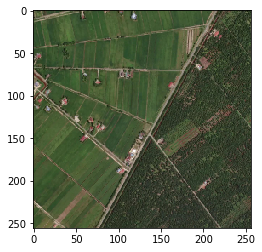

In [15]:
image = imread(sekinchan[3])
image = resize(image, (256, 256), anti_aliasing=False)
plt.imshow(image)

In [16]:
def preprocess_input(x):
    x = x.copy()
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    x[..., 0] -= mean[0]
    x[..., 1] -= mean[1]
    x[..., 2] -= mean[2]
    x[..., 0] /= std[0]
    x[..., 1] /= std[1]
    x[..., 2] /= std[2]
    return x

In [17]:
logits = sess.run(model.logits, feed_dict = {model.X: [preprocess_input(image)]})
logits.shape

(1, 256, 256, 1)

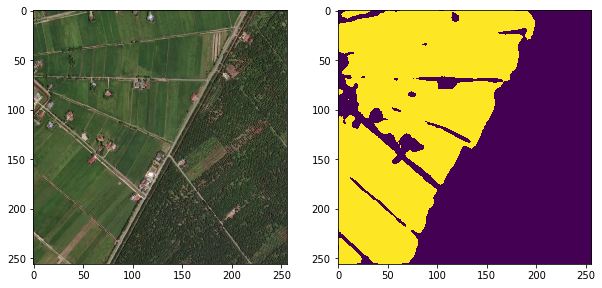

In [18]:
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(np.around(logits[0,:,:,0]))

In [14]:
saver = tf.train.Saver()
saver.save(sess, 'b4/model.ckpt')

'b4/model.ckpt'

In [19]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'gather' in n.op.lower()
        or n.name == 'input'
        or 'logits' in n.name
        or 'seq_lens' in n.name)
        and 'adam' not in n.name
        and 'global_step' not in n.name
        and 'Assign' not in n.name
        and 'ReadVariableOp' not in n.name
        and 'Gather' not in n.name
    ]
)
strings.split(',')

['input', 'logits']

In [20]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [21]:
freeze_graph('b4', strings)

INFO:tensorflow:Restoring parameters from b4/model.ckpt
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 660 variables.
INFO:tensorflow:Converted 660 variables to const ops.
4968 ops in the final graph.


In [22]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
                
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
        
    return graph

In [23]:
g = load_graph('b4/frozen_model.pb')
X = g.get_tensor_by_name('import/input:0')
logits = g.get_tensor_by_name('import/logits:0')

In [24]:
test_sess = tf.Session(graph = g)

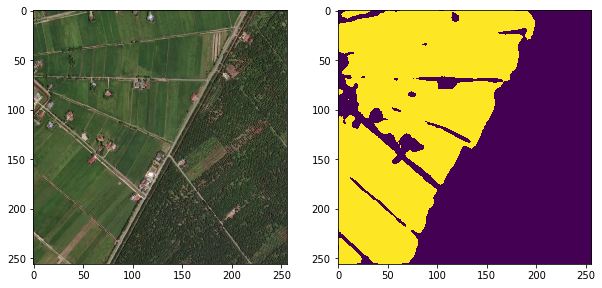

In [25]:
r = test_sess.run(logits, feed_dict = {X: [preprocess_input(image)]})
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(np.around(r[0,:,:,0]))

In [26]:
from tensorflow.tools.graph_transforms import TransformGraph

In [27]:
transforms = ['add_default_attributes',
             'remove_nodes(op=Identity, op=CheckNumerics, op=Dropout)',
             'fold_batch_norms',
             'fold_old_batch_norms',
             'quantize_weights(fallback_min=-10, fallback_max=10)',
             'strip_unused_nodes',
             'sort_by_execution_order']

pb = 'b4/frozen_model.pb'

input_graph_def = tf.GraphDef()
with tf.gfile.FastGFile(pb, 'rb') as f:
    input_graph_def.ParseFromString(f.read())

transformed_graph_def = TransformGraph(input_graph_def, 
                                           ['input'],
                                           ['logits'], transforms)
    
with tf.gfile.GFile(f'{pb}.quantized', 'wb') as f:
    f.write(transformed_graph_def.SerializeToString())

Instructions for updating:
Use tf.gfile.GFile.


In [28]:
!cp efficientnetb4-unet-jelapang-padi/events.out.tfevents* b4
!cp efficientnetb4-unet-jelapang-padi/graph.pbtxt b4

In [31]:
!rm -rf efficientnet-b4
!mkdir efficientnet-b4
!cp b4/* efficientnet-b4